# Практична робота 3
## Дизайн наукового експерименту, валідація, безпека та етика систем ШІ

**Дисципліна:** Системи штучного інтелекту в промисловості  
**Рівень:** PhD

---

### Мета роботи:
1. Створити модель для класифікації станів промислового обладнання
2. Провести статистичне порівняння алгоритмів 
3. Реалізувати атаку FGSM для генерації змагальних прикладів
4. Дослідити вплив шуму та атак на метрики якості моделі
5. Виконати етичний аудит системи

## 1. Імпорт бібліотек та налаштування середовища

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, classification_report
from scipy import stats

# Фіксація випадковості для відтворюваності експерименту
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 2.20.0
NumPy version: 1.26.4
Pandas version: 2.3.2


---
## 2. Завдання 1: Підготовка даних та базове моделювання

Ми моделюємо роботу турбіни або компресора з трьома датчиками:
1. **Vibration (Вібрація):** мм/с
2. **Temperature (Температура):** °C
3. **Pressure (Тиск):** бар

**Класифікація:** "Норма" (0) або "Аварія/Дефект" (1)

### 2.1 Генерація синтетичного промислового датасету

In [2]:
def generate_industrial_data(n_samples=2000):
    """
    Генерація синтетичного датасету промислового моніторингу.
    
    Parameters:
    -----------
    n_samples : int
        Загальна кількість зразків
        
    Returns:
    --------
    X : ndarray
        Матриця ознак (n_samples, 3)
    y : ndarray
        Вектор міток класів
    """
    # --- Генерація нормальних даних (клас 0) ---
    # Вібрація: низька, Температура: робоча, Тиск: стабільний
    X_normal = np.random.normal(
        loc=[2.0, 60.0, 10.0],    # середні значення
        scale=[0.5, 5.0, 1.0],     # стандартні відхилення
        size=(n_samples // 2, 3)
    )
    y_normal = np.zeros(n_samples // 2)

    # --- Генерація аварійних даних (клас 1) ---
    # Вібрація: підвищена, Температура: висока, Тиск: нестабільний
    X_fault = np.random.normal(
        loc=[4.5, 85.0, 12.0],
        scale=[0.8, 8.0, 2.0],
        size=(n_samples // 2, 3)
    )
    y_fault = np.ones(n_samples // 2)

    # Об'єднання та перемішування
    X = np.vstack((X_normal, X_fault))
    y = np.hstack((y_normal, y_fault))

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]

# Генерація даних
X, y = generate_industrial_data(2000)
feature_names = ['Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)']

print(f"Розмір датасету: {X.shape[0]} зразків, {X.shape[1]} ознаки")
print(f"Ознаки: {feature_names}")

Розмір датасету: 2000 зразків, 3 ознаки
Ознаки: ['Vibration (mm/s)', 'Temperature (°C)', 'Pressure (bar)']


### 2.2 Exploratory Data Analysis (EDA)

In [3]:
# Створюємо DataFrame для аналізу
df = pd.DataFrame(X, columns=feature_names)
df['Status'] = y
df['Status_Label'] = df['Status'].map({0: 'Норма', 1: 'Аварія'})

print("=" * 60)
print("ОПИСОВА СТАТИСТИКА")
print("=" * 60)
display(df.describe().round(2))

ОПИСОВА СТАТИСТИКА


,Vibration (mm/s),Temperature (°C),Pressure (bar),Status
count,2000.00,2000.00,2000.00,2000.0
mean,3.23,72.27,11.04,0.5
std,1.38,13.98,1.87,0.5
min,0.53,43.79,6.19,0.0
25%,2.02,59.92,9.75,0.0
50%,2.91,69.40,10.68,0.5
75%,4.44,84.58,12.13,1.0
max,6.98,110.22,18.49,1.0


In [4]:
print("\nСТАТИСТИКА ПО КЛАСАХ:")
print("\nКлас 0 (Норма):")
display(df[df['Status'] == 0][feature_names].describe().round(2))

print("\nКлас 1 (Аварія):")
display(df[df['Status'] == 1][feature_names].describe().round(2))


СТАТИСТИКА ПО КЛАСАХ:

Клас 0 (Норма):


,Vibration (mm/s),Temperature (°C),Pressure (bar)
count,1000.00,1000.00,1000.00
mean,2.03,59.97,10.05
std,0.49,5.04,0.98
min,0.53,43.79,6.98
25%,1.71,56.56,9.40
50%,2.03,59.91,10.04
75%,2.33,63.35,10.68
max,3.96,75.97,13.85



Клас 1 (Аварія):


,Vibration (mm/s),Temperature (°C),Pressure (bar)
count,1000.00,1000.00,1000.00
mean,4.44,84.57,12.03
std,0.82,7.93,2.01
min,1.96,60.94,6.19
25%,3.90,79.17,10.71
50%,4.44,84.59,12.06
75%,5.00,90.08,13.32
max,6.98,110.22,18.49


### 2.3 Аналіз дисбалансу класів

In [5]:
class_counts = df['Status'].value_counts()

print("АНАЛІЗ ДИСБАЛАНСУ КЛАСІВ")
print("=" * 40)
print(f"Клас 0 (Норма):  {class_counts[0]} зразків ({class_counts[0]/len(df)*100:.1f}%)")
print(f"Клас 1 (Аварія): {class_counts[1]} зразків ({class_counts[1]/len(df)*100:.1f}%)")
print(f"Співвідношення: {class_counts[0]/class_counts[1]:.2f}:1")

if abs(class_counts[0] - class_counts[1]) / len(df) < 0.1:
    print("\n✓ ВИСНОВОК: Класи збалансовані, спеціальні методи балансування не потрібні.")
else:
    print("\n⚠ ВИСНОВОК: Виявлено дисбаланс класів, рекомендується SMOTE або class_weight.")

АНАЛІЗ ДИСБАЛАНСУ КЛАСІВ
Клас 0 (Норма):  1000 зразків (50.0%)
Клас 1 (Аварія): 1000 зразків (50.0%)
Співвідношення: 1.00:1

✓ ВИСНОВОК: Класи збалансовані, спеціальні методи балансування не потрібні.


### 2.4 Візуалізація розподілу даних

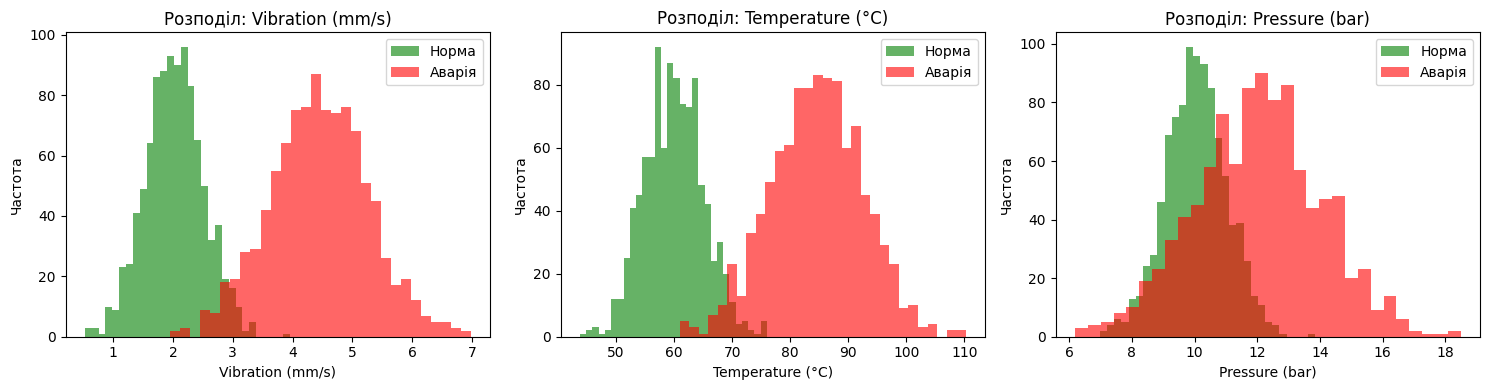

In [6]:
# Візуалізація розподілу ознак
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(feature_names):
    ax = axes[i]
    for label, color in zip([0, 1], ['green', 'red']):
        subset = df[df['Status'] == label]
        ax.hist(subset[feature], bins=30, alpha=0.6, label=f"{'Норма' if label==0 else 'Аварія'}", color=color)
    ax.set_xlabel(feature)
    ax.set_ylabel('Частота')
    ax.legend()
    ax.set_title(f'Розподіл: {feature}')

plt.tight_layout()
plt.show()

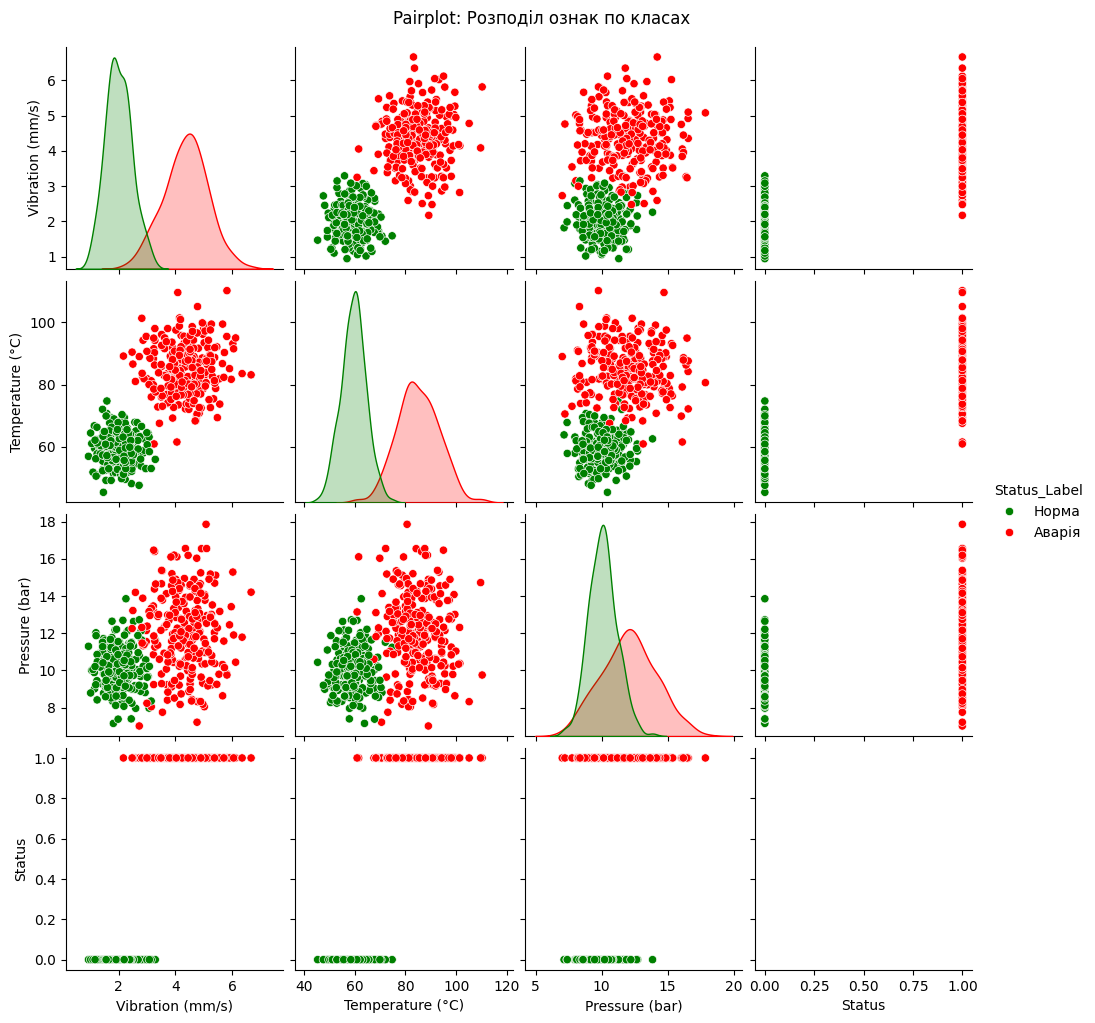

In [7]:
# Pairplot для візуалізації залежностей
sns.pairplot(df.sample(500), hue='Status_Label', diag_kind='kde', 
             palette={'Норма': 'green', 'Аварія': 'red'})
plt.suptitle('Pairplot: Розподіл ознак по класах', y=1.02)
plt.show()

### 2.5 Підготовка даних

In [8]:
# Нормалізація даних
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Розбиття на Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Розмір навчальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

Розмір навчальної вибірки: (1600, 3)
Розмір тестової вибірки: (400, 3)


---
## 3. Завдання 2: Статистичне порівняння алгоритмів

Використовуємо StratifiedKFold крос-валідацію з 10 фолдами та F1-Score як метрику.

### 3.1 Налаштування крос-валідації

In [9]:
# Налаштування крос-валідації
n_folds = 10
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='macro')

# Моделі для порівняння
models = {
    "Logistic Regression (Baseline)": LogisticRegression(random_state=42, max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
}

print(f"Кількість фолдів: {n_folds}")
print(f"Метрика: F1-Score (macro)")
print(f"\nМоделі для порівняння:")
for name in models.keys():
    print(f"  - {name}")

Кількість фолдів: 10
Метрика: F1-Score (macro)

Моделі для порівняння:
  - Logistic Regression (Baseline)
  - Gradient Boosting
  - Random Forest


### 3.2 Проведення крос-валідації

In [10]:
results = {}

print("КРОС-ВАЛІДАЦІЯ (10 ФОЛДІВ)")
print("=" * 60)

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring=f1_scorer)
    results[name] = scores
    print(f"\n{name}:")
    print(f"  Значення по фолдах: {np.round(scores, 4).tolist()}")
    print(f"  Середнє F1: {scores.mean():.4f} ± {scores.std():.4f}")

КРОС-ВАЛІДАЦІЯ (10 ФОЛДІВ)

Logistic Regression (Baseline):
  Значення по фолдах: [1.0, 0.995, 0.995, 0.995, 1.0, 1.0, 1.0, 1.0, 0.995, 0.995]
  Середнє F1: 0.9975 ± 0.0025

Gradient Boosting:
  Значення по фолдах: [0.995, 0.995, 0.995, 0.995, 1.0, 1.0, 1.0, 0.995, 0.995, 0.995]
  Середнє F1: 0.9965 ± 0.0023

Random Forest:
  Значення по фолдах: [1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 0.995]
  Середнє F1: 0.9985 ± 0.0023


In [11]:
# Таблиця порівняння
comparison_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'Середнє F1': [scores.mean() for scores in results.values()],
    'Std': [scores.std() for scores in results.values()],
    'Min': [scores.min() for scores in results.values()],
    'Max': [scores.max() for scores in results.values()]
})

print("\nТАБЛИЦЯ ПОРІВНЯННЯ МОДЕЛЕЙ")
print("=" * 60)
display(comparison_df.round(4))


ТАБЛИЦЯ ПОРІВНЯННЯ МОДЕЛЕЙ


,Модель,Середнє F1,Std,Min,Max
0,Logistic Regression (Baseline),0.9975,0.0025,0.995,1.0
1,Gradient Boosting,0.9965,0.0023,0.995,1.0
2,Random Forest,0.9985,0.0023,0.995,1.0


### 3.3 Статистичний тест

Для доведення переваги одного алгоритму над іншим використовуємо статистичні тести:

1. **Тест Шапіро-Вілка** — перевірка на нормальність розподілу
2. **Парний t-тест** — якщо розподіл нормальний
3. **Тест Вілкоксона** — якщо розподіл ненормальний

In [12]:
# Порівняння Logistic Regression vs Gradient Boosting
scores_lr = results["Logistic Regression (Baseline)"]
scores_gb = results["Gradient Boosting"]

print("СТАТИСТИЧНИЙ ТЕСТ")
print("=" * 60)
print("Порівняння: Logistic Regression vs Gradient Boosting")

# Тест Шапіро-Вілка на нормальність
shapiro_lr = stats.shapiro(scores_lr)
shapiro_gb = stats.shapiro(scores_gb)

print(f"\nТест Шапіро-Вілка на нормальність:")
print(f"  H₀: вибірка має нормальний розподіл")
print(f"  Logistic Regression: W = {shapiro_lr.statistic:.4f}, p-value = {shapiro_lr.pvalue:.4f}")
print(f"  Gradient Boosting:   W = {shapiro_gb.statistic:.4f}, p-value = {shapiro_gb.pvalue:.4f}")

alpha = 0.05
if shapiro_lr.pvalue > alpha and shapiro_gb.pvalue > alpha:
    print(f"\n  ✓ Обидва розподіли нормальні (p > {alpha}). Застосовуємо парний t-тест.")
    test_result = stats.ttest_rel(scores_lr, scores_gb)
    test_name = "Парний t-тест"
else:
    print(f"\n  ⚠ Хоча б один розподіл ненормальний (p ≤ {alpha}). Застосовуємо тест Вілкоксона.")
    test_result = stats.wilcoxon(scores_lr, scores_gb)
    test_name = "Тест Вілкоксона"

print(f"\n{test_name}:")
print(f"  H₀: медіани двох вибірок рівні")
print(f"  Статистика: {test_result.statistic:.4f}")
print(f"  P-value: {test_result.pvalue:.6f}")

if test_result.pvalue < alpha:
    print(f"\n  ✓ ВИСНОВОК: Різниця між алгоритмами є статистично значущою (p < {alpha}).")
    if scores_gb.mean() > scores_lr.mean():
        print(f"    Gradient Boosting показує кращі результати.")
    else:
        print(f"    Logistic Regression показує кращі результати.")
else:
    print(f"\n  ⚠ ВИСНОВОК: Немає підстав вважати, що алгоритми працюють по-різному (p ≥ {alpha}).")

СТАТИСТИЧНИЙ ТЕСТ
Порівняння: Logistic Regression vs Gradient Boosting

Тест Шапіро-Вілка на нормальність:
  H₀: вибірка має нормальний розподіл
  Logistic Regression: W = 0.6553, p-value = 0.0003
  Gradient Boosting:   W = 0.5942, p-value = 0.0000

  ⚠ Хоча б один розподіл ненормальний (p ≤ 0.05). Застосовуємо тест Вілкоксона.

Тест Вілкоксона:
  H₀: медіани двох вибірок рівні
  Статистика: 0.0000
  P-value: 0.500000

  ⚠ ВИСНОВОК: Немає підстав вважати, що алгоритми працюють по-різному (p ≥ 0.05).


### 3.4 Візуалізація результатів крос-валідації

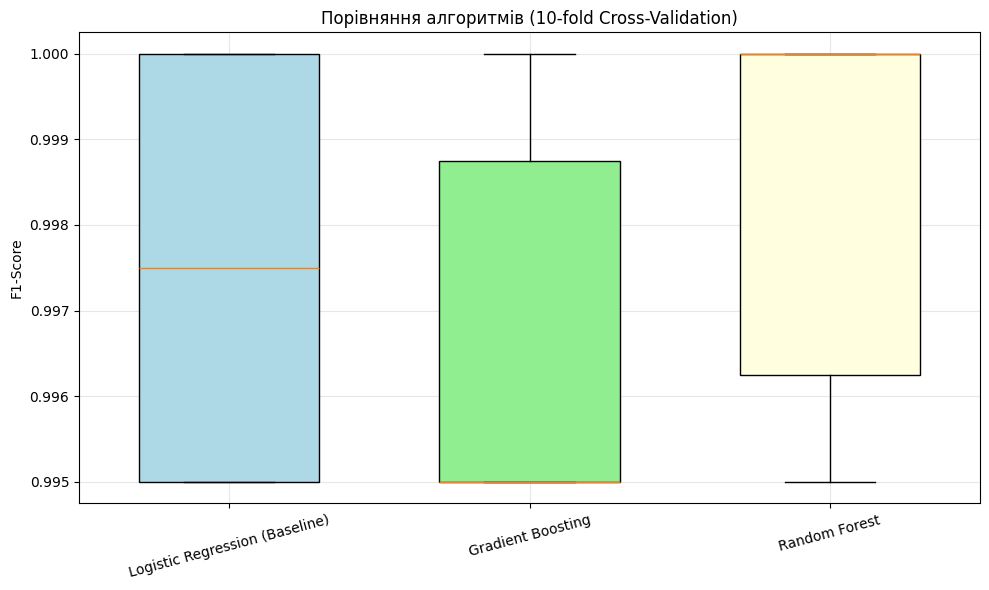

In [13]:
# Boxplot порівняння
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [results[name] for name in results.keys()]
positions = range(1, len(results) + 1)

bp = ax.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightyellow']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticklabels(list(results.keys()), rotation=15)
ax.set_ylabel('F1-Score')
ax.set_title('Порівняння алгоритмів (10-fold Cross-Validation)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. Завдання 3: Тестування на стійкість (Robustness & Security)

### Теоретичні відомості:

- **Robustness (Стійкість):** Здатність моделі зберігати точність при наявності природного шуму в даних
- **Adversarial Attacks:** Спеціально згенеровані вхідні дані, які непомітні для людини, але змушують модель помилятися

### 4.1 Побудова та навчання нейронної мережі

In [14]:
def build_model():
    """
    Побудова MLP для бінарної класифікації.
    
    Архітектура:
    - Input: 3 ознаки
    - Dense(64) + ReLU + Dropout(0.2)
    - Dense(32) + ReLU
    - Dense(1) + Sigmoid
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(3,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Побудова та навчання
nn_model = build_model()
print("Архітектура моделі:")
nn_model.summary()

Архітектура моделі:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Навчання моделі
history = nn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Оцінка базової якості
loss, acc_baseline = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"\nТочність на чистих даних (Baseline Accuracy): {acc_baseline*100:.2f}%")

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8660 - loss: 0.4365 - val_accuracy: 0.9875 - val_loss: 0.2433
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.1445 - val_accuracy: 0.9875 - val_loss: 0.0700
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.0481 - val_accuracy: 0.9937 - val_loss: 0.0253
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0165 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0122 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 0.0034
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss:

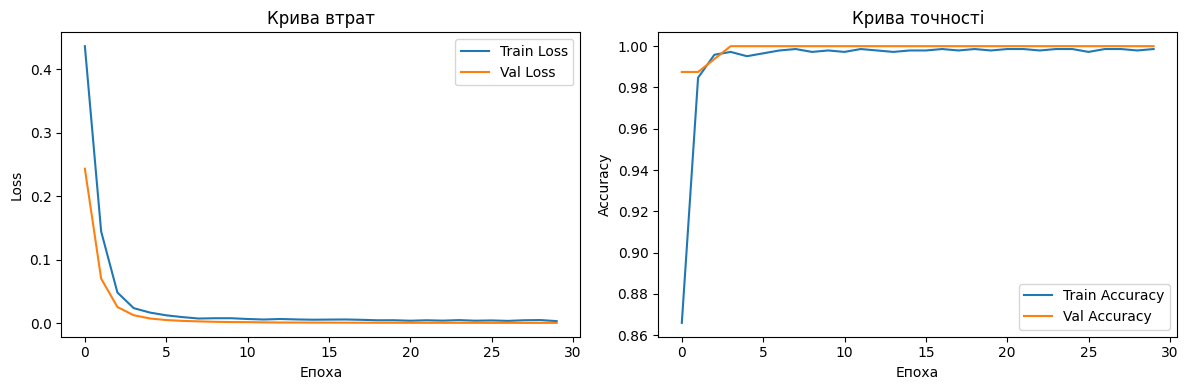

In [16]:
# Графік навчання
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Крива втрат')
axes[0].set_xlabel('Епоха')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_title('Крива точності')
axes[1].set_xlabel('Епоха')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

### 4.2 Тестування на Гаусівський шум

Імітація промислового шуму за формулою:

$$x_{noisy} = x + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

In [17]:
sigmas = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
noise_results = []

print("ТЕСТУВАННЯ НА ГАУСІВСЬКИЙ ШУМ")
print("=" * 50)
print(f"{'σ (Sigma)':<12} {'Accuracy':<12} {'Падіння точності'}")
print("-" * 50)

for sigma in sigmas:
    noise = np.random.normal(0, sigma, X_test.shape)
    X_noisy = X_test + noise
    y_pred = (nn_model.predict(X_noisy, verbose=0) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    drop = (acc_baseline - acc) * 100
    noise_results.append({'sigma': sigma, 'accuracy': acc, 'drop': drop})
    print(f"{sigma:<12.2f} {acc:.4f}       {drop:+.2f}%")

ТЕСТУВАННЯ НА ГАУСІВСЬКИЙ ШУМ
σ (Sigma)    Accuracy     Падіння точності
--------------------------------------------------
0.00         1.0000       +0.00%
0.10         0.9975       +0.25%
0.20         1.0000       +0.00%
0.30         0.9875       +1.25%
0.50         0.9700       +3.00%
0.70         0.9450       +5.50%
1.00         0.8775       +12.25%


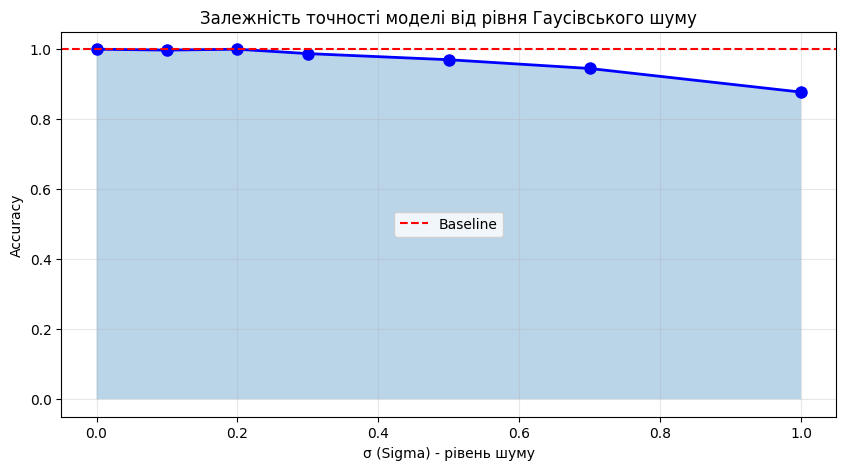

In [18]:
# Візуалізація впливу шуму
plt.figure(figsize=(10, 5))
plt.plot(sigmas, [r['accuracy'] for r in noise_results], 'o-b', linewidth=2, markersize=8)
plt.fill_between(sigmas, [r['accuracy'] for r in noise_results], alpha=0.3)
plt.title('Залежність точності моделі від рівня Гаусівського шуму')
plt.xlabel('σ (Sigma) - рівень шуму')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.axhline(y=acc_baseline, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.show()

### 4.3 FGSM атака (Fast Gradient Sign Method)

Метод генерації атак "білої скриньки" (white-box). Формула:

$$X_{adv} = X + \epsilon \cdot \text{sign}(\nabla_x J(\theta, X, y))$$

де:
- $J$ — функція втрат (binary crossentropy)
- $\nabla_x J$ — градієнт втрат по відношенню до вхідних даних
- $\epsilon$ — сила атаки

In [19]:
def fgsm_attack(model, inputs, labels, epsilon):
    """
    Генерує змагальні приклади (adversarial examples) методом FGSM.
    
    Parameters:
    -----------
    model : keras.Model
        Навчена модель
    inputs : ndarray
        Вхідні дані
    labels : ndarray
        Правильні мітки класів
    epsilon : float
        Сила атаки (множник шуму)
        
    Returns:
    --------
    adversarial_data : Tensor
        Змінені дані
    """
    # Конвертуємо дані у тензори TensorFlow
    inputs = tf.cast(inputs, tf.float32)
    labels = tf.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)  # Вказуємо TF, що треба слідкувати за вхідними даними
        prediction = model(inputs)
        loss = tf.keras.losses.binary_crossentropy(labels, prediction)

    # Обчислюємо градієнт втрат ПО ВІДНОШЕННЮ ДО ВХІДНИХ ДАНИХ (не до ваг!)
    gradient = tape.gradient(loss, inputs)

    # Беремо знак градієнта (напрямок зростання помилки)
    signed_grad = tf.sign(gradient)

    # Додаємо шум до оригінальних даних
    adversarial_data = inputs + epsilon * signed_grad

    return adversarial_data

print("Функція FGSM атаки визначена.")

Функція FGSM атаки визначена.


In [20]:
epsilons = [0.0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
fgsm_results = []

y_sample = y_test.reshape(-1, 1)

print("FGSM АТАКА")
print("=" * 50)
print(f"{'Epsilon':<12} {'Accuracy':<12} {'Падіння точності'}")
print("-" * 50)

for eps in epsilons:
    X_adv = fgsm_attack(nn_model, X_test, y_sample, epsilon=eps)
    y_pred_adv = (nn_model.predict(X_adv, verbose=0) > 0.5).astype(int)
    acc = accuracy_score(y_sample, y_pred_adv)
    drop = (acc_baseline - acc) * 100
    fgsm_results.append({'epsilon': eps, 'accuracy': acc, 'drop': drop})
    print(f"{eps:<12.2f} {acc:.4f}       {drop:+.2f}%")

FGSM АТАКА
Epsilon      Accuracy     Падіння точності
--------------------------------------------------
0.00         1.0000       +0.00%
0.05         0.9975       +0.25%
0.10         0.9950       +0.50%
0.20         0.9825       +1.75%
0.30         0.9550       +4.50%
0.50         0.8275       +17.25%
0.70         0.6350       +36.50%
1.00         0.3125       +68.75%


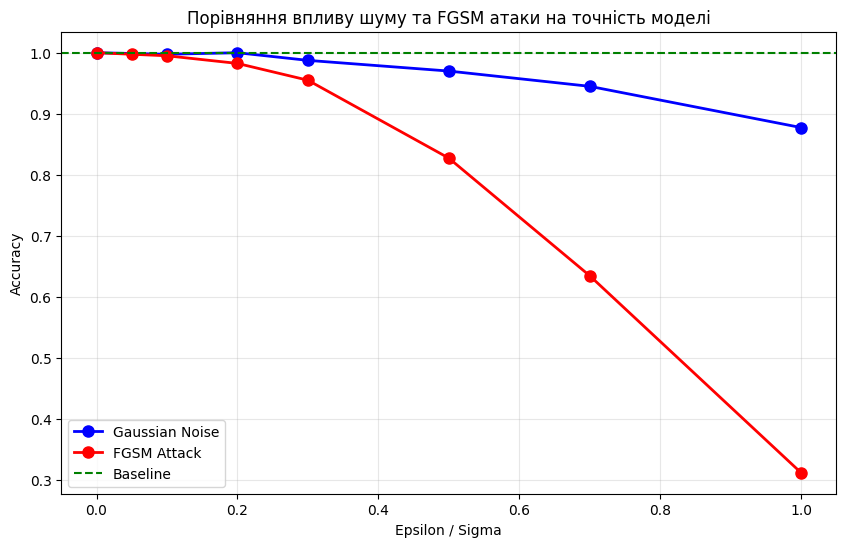

In [21]:
# Візуалізація: порівняння шуму та атаки
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot([r['sigma'] for r in noise_results], [r['accuracy'] for r in noise_results], 
        'o-b', linewidth=2, markersize=8, label='Gaussian Noise')
ax.plot([r['epsilon'] for r in fgsm_results], [r['accuracy'] for r in fgsm_results], 
        'o-r', linewidth=2, markersize=8, label='FGSM Attack')

ax.axhline(y=acc_baseline, color='green', linestyle='--', label='Baseline')
ax.set_title('Порівняння впливу шуму та FGSM атаки на точність моделі')
ax.set_xlabel('Epsilon / Sigma')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### 4.4 Детальний аналіз атаки

Як змінилися фізичні показники після атаки?

In [22]:
# Вибір тестового зразка
idx = 0
original_sample = X_test[idx].reshape(1, 3)
true_label = y_test[idx].reshape(1, 1)

# Генерація атаки з Epsilon = 0.5
adv_sample = fgsm_attack(nn_model, original_sample, true_label, epsilon=0.5).numpy()

# --- Денормалізація (повернення до реальних одиниць) ---
original_phys = scaler.inverse_transform(original_sample)[0]
adv_phys = scaler.inverse_transform(adv_sample)[0]

# Передбачення моделі
pred_clean = nn_model.predict(original_sample, verbose=0)[0][0]
pred_adv = nn_model.predict(adv_sample, verbose=0)[0][0]

true_class = int(true_label[0][0])
print(f"ДЕТАЛЬНИЙ АНАЛІЗ АТАКИ НА ЗРАЗОК (ε = 0.5)")
print("=" * 65)
print(f"Істинний клас: {true_class} ({'Аварія' if true_class == 1 else 'Норма'})")
print("-" * 65)
print(f"{'Показник':<25} {'Оригінал':<15} {'Атака':<15} {'Різниця'}")
print("-" * 65)

for i, name in enumerate(feature_names):
    diff = adv_phys[i] - original_phys[i]
    print(f"{name:<25} {original_phys[i]:<15.2f} {adv_phys[i]:<15.2f} {diff:+.2f}")

print("-" * 65)
print(f"\nЙмовірність аварії (чисті дані):    {pred_clean:.4f} -> Рішення: {int(pred_clean > 0.5)}")
print(f"Ймовірність аварії (атаковані дані): {pred_adv:.4f} -> Рішення: {int(pred_adv > 0.5)}")

if int(pred_clean > 0.5) != int(pred_adv > 0.5):
    print("\n⚠️  АТАКА УСПІШНА: модель змінила своє рішення!")
else:
    print("\n✓ Модель стійка: рішення не змінилося.")

ДЕТАЛЬНИЙ АНАЛІЗ АТАКИ НА ЗРАЗОК (ε = 0.5)
Істинний клас: 0 (Норма)
-----------------------------------------------------------------
Показник                  Оригінал        Атака           Різниця
-----------------------------------------------------------------
Vibration (mm/s)          2.47            3.16            +0.69
Temperature (°C)          55.09           62.08           +6.99
Pressure (bar)            9.78            10.71           +0.93
-----------------------------------------------------------------

Ймовірність аварії (чисті дані):    0.0000 -> Рішення: 0
Ймовірність аварії (атаковані дані): 0.0059 -> Рішення: 0

✓ Модель стійка: рішення не змінилося.


### 4.5 Adversarial Training (Метод захисту)

Один з найефективніших методів захисту — додавання атакованих прикладів у навчальну вибірку.

In [23]:
# Збереження результатів до Adversarial Training для порівняння
fgsm_results_before_at = fgsm_results.copy()

# 1. Генеруємо атаковані дані на основі Train set
print("ADVERSARIAL TRAINING")
print("=" * 60)
print("Крок 1: Генерація атакованих даних для train set (ε=0.2)...")
X_train_adv = fgsm_attack(nn_model, X_train, y_train.reshape(-1, 1), epsilon=0.2)

# 2. Об'єднуємо чисті та атаковані дані
print("Крок 2: Об'єднання чистих та атакованих даних...")
X_combined = np.vstack((X_train, X_train_adv))
y_combined = np.hstack((y_train, y_train))
print(f"Розмір розширеного датасету: {X_combined.shape}")

# 3. Донавчаємо модель
print("Крок 3: Донавчання моделі...")
nn_model.fit(X_combined, y_combined, epochs=10, batch_size=32, verbose=0)
print("Донавчання завершено.")

ADVERSARIAL TRAINING
Крок 1: Генерація атакованих даних для train set (ε=0.2)...
Крок 2: Об'єднання чистих та атакованих даних...
Розмір розширеного датасету: (3200, 3)
Крок 3: Донавчання моделі...
Донавчання завершено.


In [24]:
# Тестування після Adversarial Training
print("\nТестування після Adversarial Training:")
print(f"\n{'Epsilon':<12} {'До AT':<15} {'Після AT':<15} {'Покращення'}")
print("-" * 55)

fgsm_results_after_at = []
for eps in [0.0, 0.1, 0.2, 0.3, 0.5]:
    X_adv_test = fgsm_attack(nn_model, X_test, y_sample, epsilon=eps)
    y_pred_new = (nn_model.predict(X_adv_test, verbose=0) > 0.5).astype(int)
    acc_new = accuracy_score(y_sample, y_pred_new)
    
    # Знаходимо стару точність
    old_acc = next(r['accuracy'] for r in fgsm_results_before_at if r['epsilon'] == eps)
    improvement = (acc_new - old_acc) * 100
    
    fgsm_results_after_at.append({'epsilon': eps, 'before': old_acc, 'after': acc_new, 'improvement': improvement})
    print(f"{eps:<12.2f} {old_acc:.4f}         {acc_new:.4f}         {improvement:+.2f}%")


Тестування після Adversarial Training:

Epsilon      До AT           Після AT        Покращення
-------------------------------------------------------
0.00         1.0000         0.9975         -0.25%
0.10         0.9950         0.9950         +0.00%
0.20         0.9825         0.9725         -1.00%
0.30         0.9550         0.9500         -0.50%
0.50         0.8275         0.8425         +1.50%


---
## 5. Завдання 4: Етичний аудит

### 5.1 SHAP Values аналіз (пояснюваність моделі)

In [25]:
try:
    import shap
    
    print("SHAP VALUES АНАЛІЗ")
    print("=" * 60)
    
    # Беремо підмножину для прискорення обчислень
    background = X_train[:100]
    test_samples = X_test[:10]
    
    # Функція для предсказания
    def model_predict(x):
        return nn_model.predict(x, verbose=0)
    
    # Створюємо explainer
    explainer = shap.KernelExplainer(model_predict, background)
    shap_values = explainer.shap_values(test_samples)
    
    # Обробка різних форматів SHAP values
    if isinstance(shap_values, list):
        shap_values = np.array(shap_values[0]) if len(shap_values) == 1 else np.array(shap_values)
    if len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 0]
    
    # Важливість ознак
    mean_abs_shap = np.abs(shap_values).mean(axis=0).flatten()
    
    print("\nВАЖЛИВІСТЬ ОЗНАК (середні |SHAP|):")
    importance_df = pd.DataFrame({
        'Ознака': feature_names,
        'Важливість': mean_abs_shap
    }).sort_values('Важливість', ascending=False)
    display(importance_df)
    
    most_important = feature_names[np.argmax(mean_abs_shap)]
    print(f"\nНайважливіша ознака: {most_important}")
    
    shap_available = True
    
except ImportError:
    print("⚠️  Бібліотека SHAP не встановлена.")
    print("   Встановіть її командою: pip install shap")
    print("\nВиконуємо альтернативний аналіз важливості ознак...")
    shap_available = False

SHAP VALUES АНАЛІЗ


  0%|          | 0/10 [00:00<?, ?it/s]


ВАЖЛИВІСТЬ ОЗНАК (середні |SHAP|):


,Ознака,Важливість
0,Vibration (mm/s),0.253891
1,Temperature (°C),0.204728
2,Pressure (bar),0.027254



Найважливіша ознака: Vibration (mm/s)


In [26]:
# Альтернативний метод - Permutation Importance
if not shap_available:
    def manual_permutation_importance(model, X, y, n_repeats=10):
        """Розрахунок важливості ознак через перемішування."""
        baseline_pred = (model.predict(X, verbose=0) > 0.5).astype(int).flatten()
        baseline_acc = accuracy_score(y, baseline_pred)
        
        importances = []
        for i in range(X.shape[1]):
            scores = []
            for _ in range(n_repeats):
                X_permuted = X.copy()
                np.random.shuffle(X_permuted[:, i])
                y_pred = (model.predict(X_permuted, verbose=0) > 0.5).astype(int).flatten()
                acc = accuracy_score(y, y_pred)
                scores.append(baseline_acc - acc)
            importances.append({'mean': np.mean(scores), 'std': np.std(scores)})
        return importances, baseline_acc
    
    importances, baseline_acc = manual_permutation_importance(nn_model, X_test, y_test, n_repeats=10)
    
    print("\nВАЖЛИВІСТЬ ОЗНАК (Permutation Importance):")
    for i, name in enumerate(feature_names):
        print(f"  {name}: {importances[i]['mean']:.4f} ± {importances[i]['std']:.4f}")

### 5.2 Confusion Matrix та аналіз помилок

CONFUSION MATRIX


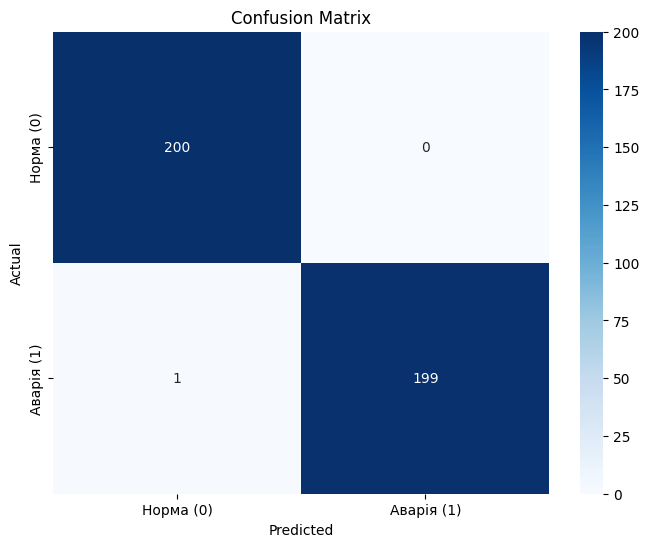


True Negative (TN):  200
True Positive (TP):  199
False Positive (FP): 0
False Negative (FN): 1


In [27]:
# Обчислюємо confusion matrix
y_pred_final = (nn_model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred_final)

print("CONFUSION MATRIX")
print("=" * 40)

# Візуалізація
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Норма (0)', 'Аварія (1)'],
            yticklabels=['Норма (0)', 'Аварія (1)'],
            ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

TN, FP, FN, TP = cm.ravel()
print(f"\nTrue Negative (TN):  {TN}")
print(f"True Positive (TP):  {TP}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")

In [28]:
# Метрики якості
print("\nМЕТРИКИ ЯКОСТІ")
print("=" * 40)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

metrics_df = pd.DataFrame({
    'Метрика': ['Precision', 'Recall (Sensitivity)', 'Specificity', 'F1-Score'],
    'Значення': [precision, recall, specificity, f1],
    'Формула': ['TP/(TP+FP)', 'TP/(TP+FN)', 'TN/(TN+FP)', '2·P·R/(P+R)']
})
display(metrics_df)


МЕТРИКИ ЯКОСТІ


,Метрика,Значення,Формула
0,Precision,1.000000,TP/(TP+FP)
1,Recall (Sensitivity),0.995000,TP/(TP+FN)
2,Specificity,1.000000,TN/(TN+FP)
3,F1-Score,0.997494,2·P·R/(P+R)


### 5.3 Аналіз етичних ризиків

In [34]:
print("АНАЛІЗ ЕТИЧНИХ РИЗИКІВ")
print("=" * 70)

print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║  ТИП ПОМИЛКИ        │  НАСЛІДОК У ПРОМИСЛОВОСТІ                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  False Positive     │  Зупинка конвеєра, коли аварії немає.          ║
║  (FP = {FP:3d})         │  Втрати від простою виробництва.               ║
╠══════════════════════════════════════════════════════════════════════╣
║  False Negative     │  Пропущена реальна аварія.                     ║
║  (FN = {FN:3d})         │  Випуск браку, пошкодження обладнання,         ║
║                     │  ризик для персоналу.                          ║
╚══════════════════════════════════════════════════════════════════════╝
""")

print("ВИСНОВОК:")
if FN > FP:
    print("⚠️  False Negative (FN) є критичнішим у промисловому контексті!")
    print("    Рекомендація: налаштувати поріг класифікації для зменшення FN.")
elif FN == 0 and FP == 0:
    print("✓ Модель досягла ідеальних результатів на тестовій вибірці.")
    print("  Увага: на реальних даних результати можуть відрізнятися.")
else:
    print(f"  False Positive: {FP}, False Negative: {FN}")
    print("  Необхідно збалансувати компроміс між типами помилок.")

АНАЛІЗ ЕТИЧНИХ РИЗИКІВ

╔══════════════════════════════════════════════════════════════════════╗
║  ТИП ПОМИЛКИ        │  НАСЛІДОК У ПРОМИСЛОВОСТІ                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  False Positive     │  Зупинка конвеєра, коли аварії немає.          ║
║  (FP =   0)         │  Втрати від простою виробництва.               ║
╠══════════════════════════════════════════════════════════════════════╣
║  False Negative     │  Пропущена реальна аварія.                     ║
║  (FN =   1)         │  Випуск браку, пошкодження обладнання,         ║
║                     │  ризик для персоналу.                          ║
╚══════════════════════════════════════════════════════════════════════╝

ВИСНОВОК:
⚠️  False Negative (FN) є критичнішим у промисловому контексті!
    Рекомендація: налаштувати поріг класифікації для зменшення FN.


---
## 6. Загальний підсумок

In [30]:
print("\n" + "=" * 70)
print("ЗАГАЛЬНИЙ ПІДСУМОК ПРАКТИЧНОЇ РОБОТИ")
print("=" * 70)

print(f"""
1. ДАТАСЕТ:
   • Синтетичні дані промислового моніторингу (турбіна/компресор)
   • {X.shape[0]} зразків, {X.shape[1]} ознаки (вібрація, температура, тиск)
   • Класи збалансовані 50/50

2. ПОРІВНЯННЯ АЛГОРИТМІВ (10-fold CV):
   • Logistic Regression: F1 = {results['Logistic Regression (Baseline)'].mean():.4f}
   • Gradient Boosting:   F1 = {results['Gradient Boosting'].mean():.4f}
   • Random Forest:       F1 = {results['Random Forest'].mean():.4f}
   • Статистичний тест:   p-value = {test_result.pvalue:.4f}

3. ROBUSTNESS (Neural Network):
   • Baseline accuracy: {acc_baseline*100:.2f}%
   • При σ=0.5 (Gaussian noise): {noise_results[4]['accuracy']*100:.2f}%
   • При ε=0.5 (FGSM attack):    {fgsm_results_before_at[5]['accuracy']*100:.2f}%

4. ADVERSARIAL TRAINING:
   • Покращення стійкості при ε=0.5: {fgsm_results_after_at[4]['improvement']:+.2f}%

5. ЕТИКА:
   • False Positive (зайві зупинки): {FP}
   • False Negative (пропущені аварії): {FN}
""")

print("=" * 70)
print("ПРАКТИЧНА РОБОТА ЗАВЕРШЕНА")
print("=" * 70)


ЗАГАЛЬНИЙ ПІДСУМОК ПРАКТИЧНОЇ РОБОТИ

1. ДАТАСЕТ:
   • Синтетичні дані промислового моніторингу (турбіна/компресор)
   • 2000 зразків, 3 ознаки (вібрація, температура, тиск)
   • Класи збалансовані 50/50

2. ПОРІВНЯННЯ АЛГОРИТМІВ (10-fold CV):
   • Logistic Regression: F1 = 0.9975
   • Gradient Boosting:   F1 = 0.9965
   • Random Forest:       F1 = 0.9985
   • Статистичний тест:   p-value = 0.5000

3. ROBUSTNESS (Neural Network):
   • Baseline accuracy: 100.00%
   • При σ=0.5 (Gaussian noise): 97.00%
   • При ε=0.5 (FGSM attack):    82.75%

4. ADVERSARIAL TRAINING:
   • Покращення стійкості при ε=0.5: +1.50%

5. ЕТИКА:
   • False Positive (зайві зупинки): 0
   • False Negative (пропущені аварії): 1

ПРАКТИЧНА РОБОТА ЗАВЕРШЕНА
